# Preamble

In [116]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import csv
import pandas as pd
import h5py
import gc  # garbage collection
# Scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# PyTorch libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import ToTensor, Normalize 
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))
## ONNX
# import onnx
# import onnxruntime
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],  # "Times", "Palatino", "New Century Schoolbook", "Bookman", 
    })

When using __Google Colab__, run the following cell

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# code_dir = "/content/drive/MyDrive/KUL/MAI thesis/Code"
# master_dir = os.path.join(code_dir, "..")
# os.chdir(code_dir)
# print(os.getcwd())

In [4]:
# Load own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p

Point towards the folder where we store the EOS tables (__Note:__ they are not in the Github as these are very large files. Look inside the notebook to see which EOS tables we use, they can be downloaded from the stellarcollapse webpage.)

In [5]:
eos_tables_dir = os.path.join("D:/Coding/Datasets/eos_tables")  # offline
# eos_tables_dir = os.path.join(master_dir, "Data")  # in Google Colab
print(f"Going to look for EOS tables at {eos_tables_dir}")

Going to look for EOS tables at D:/Coding/Datasets/eos_tables


For the training, check if GPU is available (**Google Colab**):

In [6]:
if torch.cuda.is_available(): 
    DEVICE = "cuda:0" 
    torch.set_default_device('cuda')
else: 
    DEVICE = "cpu" 
print(f"Device for training: {DEVICE}")

Device for training: cpu


# Introduction

Here, we try to find a way to generalize the NN approach from the first semester to the situation of tabular EOS. 

*Note*: We use HDF5 files, but you have to close them manually. Forgot to close one? Check if there is still an open HDF5 file with garbage collect in the memory, and close it:

In [138]:
# Browse through objects
for obj in gc.get_objects():
    # see if is an HDF5 file
    if isinstance(obj, h5py.File):
        print(obj)
        try:
            obj.close()
            del obj
        except:
            pass
gc.collect()

<Closed HDF5 file>
<Closed HDF5 file>


0

# Exploring EOS tables

Specify the EOS. Other downloaded EOS tables: `"GShen_NL3EOS_rho280_temp180_ye52_version_1.1_20120817.h5"`, `"SLy4_0000_rho391_temp163_ye66.h5"`

In [275]:
# Then specify which we are going to use here
eos_table_filename = "SLy4_0000_rho391_temp163_ye66.h5"

Read in the SLy4 EOS table using our py script: (make sure to close HDF5 files!)

In [276]:
# Open EOS table
eos_table = physics.read_eos_table(os.path.join(eos_tables_dir, eos_table_filename))
# Read in the most important variables and convert them to np arrays
dim_ye, dim_temp, dim_rho = eos_table["pointsye"][()][0], eos_table["pointstemp"][()][0], eos_table["pointsrho"][()][0]
logrho       = eos_table["logrho"][()]
logtemp      = eos_table["logtemp"][()]
ye           = eos_table["ye"][()]
logpress     = eos_table["logpress"][()]
logenergy    = eos_table["logenergy"][()]
energy_shift = eos_table["energy_shift"][()][0]
cs2          = eos_table["cs2"][()]
print(f"This EOS table has dimensions (ye, T, rho): {dim_ye} x {dim_temp} x {dim_rho}")
# Small test to see the output of the EOS table
test_ye      = eos_table["ye"][()][0]
test_temp    = eos_table["logtemp"][()][0]
test_rho     = eos_table["logrho"][()][0]
# Get an example output
test_press, test_eps = eos_table["logpress"][()][0, 0, 0], eos_table["logenergy"][()][0, 0, 0]
print(f"Example: ({test_rho}, {test_temp}, {test_ye}) we have (log eps, log p, cs2): ({test_eps}, {test_press}, {cs2[0, 0, 0]}).")
eos_table.close()

This EOS table has dimensions (ye, T, rho): 66 x 163 x 391
Example: (3.0239960056064277, -3.0, 0.005) we have (log eps, log p, cs2): (19.2791052025363, 17.99956975587081, 1575737840983096.0).


__Extra:__ Save only most important variables for epsilon to energy procedure.

In [277]:
# with h5py.File(os.path.join(eos_tables_dir, "energy_table.h5"), 'w') as f:
#     # Save the features and labels data
#     dataset = f.create_dataset("logrho", data=logrho)
#     dataset = f.create_dataset("logtemp", data=logtemp)
#     dataset = f.create_dataset("ye", data=ye)
#     dataset = f.create_dataset("logenergy", data=logenergy)
#     dataset = f.create_dataset("energy_shift", data=energy_shift)

In [278]:
# np.savetxt("energy_shift.txt", [energy_shift])

What is the input range of this table?

In [279]:
print(f"logrho    range:({min(logrho)}, {max(logrho)})")
print(f"logtemp range:({min(logtemp)}, {max(logtemp)})")
print(f"ye             range:({min(ye)}, {max(ye)})")

logrho    range:(3.0239960056064277, 16.023996005606428)
logtemp range:(-3.0, 2.4000000000000004)
ye             range:(0.005, 0.655)


See what is inside this EOS table

In [280]:
# # Iterate over keys and save them to list for simplified viewing
# keys = []
# for key in eos_table:
#     keys.append(key)
# print(keys)
# print(len(keys))

## Output
# ['Abar', 'Albar', 'MERGE-space.in', 'MERGE-src.tar.gz', 'MERGE-tables.in', 'MERGE-transition.in', 'SNA-skyrme.in', 'SNA-space.in', 'SNA-src.tar.gz', 'Xa', 'Xh', 'Xl', 'Xn', 'Xp', 'Zbar', 'Zlbar', 'cs2', 'dedt', 'dpderho', 'dpdrhoe', 'energy_shift', 'entropy', 'gamma', 'have_rel_cs2', 'logenergy', 'logpress', 'logrho', 'logtemp', 'meffn', 'meffp', 'mu_e', 'mu_n', 'mu_p', 'muhat', 'munu', 'pointsrho', 'pointstemp', 'pointsye', 'r', 'u', 'ye']

The universal neural network architecture that we will rely on for the tasks defined below:

In [281]:
class Net(nn.Module):
    """
    Implements a simple feedforward neural network.
    """
    def __init__(self, nb_of_inputs: int = 3, nb_of_outputs: int = 1, h: list = [600, 200], reg: bool = False, 
                 activation_function = torch.nn.Sigmoid, output_bias=True) -> None:
        """
        Initialize the neural network class.
        """
        # Call the super constructor first
        super(Net, self).__init__()
        
        # For convenience, save the sizes of the hidden layers as fields as well
        self.h = h
        # Add visible layers as well: input is 3D and output is 1D
        self.h_augmented = [nb_of_inputs] + h + [nb_of_outputs]

        # Add field to specify whether or not we do regularization
        self.regularization = reg

        # Define the layers:
        for i in range(len(self.h_augmented)-1):
            if i == len(self.h_augmented)-2:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1], bias=output_bias))
            else:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1]))
                setattr(self, f"activation{i+1}", activation_function())

    def forward(self, x):
        """
        Computes a forward step given the input x.
        :param x: Input for the neural network.
        :return: x: Output neural network
        """
        
        for i, module in enumerate(self.modules()):
            # The first module is the whole NNC2P object, continue
            if i == 0:
                continue
            x = module(x)

        return x

# First goal: NNEOS

__NNEOS__: try to replicate the EOS table (at least the core variables we are interested in) using the "input" variables logrho, logtemp, ye.

## Convert EOS table to table of training examples

In [317]:
# Get the filename of converted training data
filename = os.path.join(eos_tables_dir, "train_eos_table.h5")

In [318]:
# # Create new dataset (if desired)
# # Specify output vars as "var_names" argument in this function - see physics.py
# eos_table = physics.read_eos_table(os.path.join(eos_tables_dir, eos_table_filename))
# physics.generate_eos_data(eos_table, save_name=filename)
# eos_table.close()

In [472]:
# Load the dataset afterwards
train_eos_table = h5py.File(filename, 'r')
# Get the data saved in the HDF5 file
features  = train_eos_table["features"][:]
labels    = train_eos_table["labels"][:]
var_names = train_eos_table["var_names"][:]
size_eos_table = len(features)
print(f"The output variables are {var_names}. Number of examples: {size_eos_table}")
# Close the file
train_eos_table.close()

The output variables are [b'logenergy' b'logpress' b'cs2']. Number of examples: 4206378


## Preprocess the data

An example of a features/labels pair:

In [473]:
print(np.min(features, axis=0))
print(np.max(features, axis=0))

[ 3.02399601 -3.          0.005     ]
[16.02399601  2.4         0.655     ]


In [474]:
print(features[0])
print(labels[0])

[ 3.02399601 -3.          0.005     ]
[1.92791052e+01 1.79995698e+01 1.57573784e+15]


### Delete negative $c_s^2$ values

There are apparently a few negative values for the speed of sound... They are likely a bug in the code? We'll remove them.

In [475]:
cs_values = labels[:, 2]
cs_values

array([1.57573784e+15, 1.53801127e+15, 1.49992954e+15, ...,
       1.34334539e+21, 1.34446322e+21, 1.34570741e+21])

In [476]:
negative_indices = np.argwhere(cs_values < 0)
negative_indices

array([[3629826],
       [3629892],
       [3629958],
       [3630024],
       [3630090],
       [3630156],
       [3630222],
       [3630288],
       [3630354]], dtype=int64)

In [477]:
features = np.delete(features, negative_indices, axis=0)
labels = np.delete(labels, negative_indices, axis=0)

### Use log values for $c_s^2$

If we are using cs2 in the output, you see that its values are huge -- we will also output log cs2 values to improve training the network:

In [478]:
# Note: binary text!
if b"cs2" in var_names:
    cs_index = np.where(var_names == b"cs2")[0][0]
    labels[:, cs_index] = np.log(labels[:, cs_index])

In [479]:
print(features[0])
print(labels[0])

[ 3.02399601 -3.          0.005     ]
[19.2791052  17.99956976 34.99350003]


### Explore the training data

The range of the datasets:

In [480]:
min_values = np.min(labels, axis=0)
print(min_values)
max_values = np.max(labels, axis=0)
print(max_values)

[19.02463658 17.42022108 33.74498022]
[33.15270695 38.1640256  48.77010732]


### Convert to Torch `Datasets` for training the network

Get the training data as DataSet and DataLoader objects. Note on normalization: we fit transform on the training data, then use the fitted scaler object to transform (i.e. using same transformation as the training data) the test set.

In [481]:
# For normalization, use sklearn's StandardScaler
scaler = StandardScaler()
# We fit the scaler on the entire dataset to have it as efficient as possible
scaler.fit(features)
# Do train test split here
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
# "Cutoff": only use certain portion of the data for training and testing, to speed up training when tuning architecture 
cutoff = 0.05
print(len(train_features))
end = int(cutoff*len(train_features))
train_features = train_features[:end]
train_labels = train_labels[:end]
end = int(cutoff*len(test_features))
test_features = test_features[:end]
test_labels = test_labels[:end]
print(len(train_features))
# Convert to PyTorch Datasets as we defined them
train_dataset = data.HDF5Dataset(train_features, train_labels, normalization_function = scaler.transform) 
test_dataset  = data.HDF5Dataset(test_features, test_labels, normalization_function = scaler.transform)
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size = 32)
test_dataloader  = DataLoader(test_dataset, batch_size = 32)

3154776
157738


In [482]:
print(scaler.mean_)
print(scaler.scale_)

[ 9.52398588 -0.29999922  0.33000018]
[3.7623846  1.5684403  0.19050388]


### Training and inference

Create a new instance of the Net:

In [335]:
model = Net(nb_of_inputs=3, nb_of_outputs=3, h=[20, 20], activation_function=torch.nn.ReLU, output_bias=True).double()
model

Net(
  (linear1): Linear(in_features=3, out_features=20, bias=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=20, out_features=3, bias=True)
)

Or load from earlier:

In [336]:
# model = torch.load("../Models/taboes_3_20_20_3_relu.pt")
# test_input = [[1, 1, 1]]
# test_input = scaler.transform(test_input)
# test_input = torch.from_numpy(test_input).float()
# with torch.no_grad():
#     pred = model.float()(test_input).numpy()[0]
# print(pred)

In [337]:
print(scaler.mean_)
print(scaler.scale_)

[ 9.52398588 -0.29999922  0.33000018]
[3.7623846  1.5684403  0.19050388]


In [338]:
# model.state_dict()["linear1.bias"]

In [339]:
nnc2p.count_parameters(model)

563

Create a trainer object:

In [340]:
trainer = nnc2p.Trainer(model, 1e-2, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

Train the network

In [342]:
trainer.train(number_of_epochs = 1000)

Training the model for 1000 epochs.

 Epoch 0 
 --------------
Train loss: 2.58E-02
Test  loss: 2.58E-02

 Epoch 1 
 --------------
Train loss: 1.78E-02
Test  loss: 1.78E-02

 Epoch 2 
 --------------
Train loss: 1.44E-02
Test  loss: 1.44E-02

 Epoch 3 
 --------------
Train loss: 1.49E-02
Test  loss: 1.48E-02

 Epoch 4 
 --------------
Train loss: 1.58E-02
Test  loss: 1.58E-02

 Epoch 5 
 --------------
Train loss: 2.64E-02
Test  loss: 2.64E-02

 Epoch 6 
 --------------
Train loss: 2.59E-02
Test  loss: 2.57E-02

 Epoch 7 
 --------------
Train loss: 1.81E-02
Test  loss: 1.80E-02

 Epoch 8 
 --------------
Train loss: 1.86E-02
Test  loss: 1.85E-02

 Epoch 9 
 --------------
Train loss: 1.88E-02
Test  loss: 1.88E-02

 Epoch 10 
 --------------
Train loss: 1.26E-02
Test  loss: 1.26E-02

 Epoch 11 
 --------------
Train loss: 3.04E-02
Test  loss: 3.03E-02

 Epoch 12 
 --------------
Train loss: 3.42E-02
Test  loss: 3.41E-02

 Epoch 13 
 --------------
Train loss: 2.64E-02
Test  loss: 2.6

Train loss: 2.70E-03
Test  loss: 2.76E-03

 Epoch 116 
 --------------
Train loss: 2.70E-03
Test  loss: 2.76E-03

 Epoch 117 
 --------------
Train loss: 2.71E-03
Test  loss: 2.77E-03

 Epoch 118 
 --------------
Train loss: 2.70E-03
Test  loss: 2.77E-03

 Epoch 119 
 --------------
Train loss: 2.69E-03
Test  loss: 2.75E-03

 Epoch 120 
 --------------
Train loss: 2.70E-03
Test  loss: 2.76E-03

 Epoch 121 
 --------------
Train loss: 2.68E-03
Test  loss: 2.74E-03

 Epoch 122 
 --------------
Train loss: 2.68E-03
Test  loss: 2.74E-03

 Epoch 123 
 --------------
Train loss: 2.69E-03
Test  loss: 2.75E-03

 Epoch 124 
 --------------
Train loss: 2.68E-03
Test  loss: 2.74E-03

 Epoch 125 
 --------------
Train loss: 2.68E-03
Test  loss: 2.74E-03

 Epoch 126 
 --------------
Train loss: 2.67E-03
Test  loss: 2.73E-03

 Epoch 127 
 --------------
Train loss: 2.68E-03
Test  loss: 2.74E-03

 Epoch 128 
 --------------
Train loss: 2.71E-03
Test  loss: 2.78E-03

 Epoch 129 
 --------------
Train 


KeyboardInterrupt



Quickly check some error rates

In [343]:
test_input = train_features
test_input = scaler.transform(test_input)
test_input = torch.from_numpy(test_input).float()
with torch.no_grad():
    predictions = model.float()(test_input)
    predictions = predictions.numpy()
print(nnc2p.l1_norm(predictions, train_labels))
print(nnc2p.l2_norm(predictions, train_labels))
print(nnc2p.linfty_norm(predictions, train_labels))

[0.02167531 0.03401273 0.04514123]
[0.00083762 0.00171825 0.00472396]
[0.18167502 0.36557974 1.67024518]


Baseline: the bigger model

In [344]:
# baseline = torch.load("../Models/tabeos_3_50_50_3.pt")
# test_input = train_features
# test_input = scaler.transform(test_input)
# test_input = torch.from_numpy(test_input).float()
# with torch.no_grad():
#     predictions = baseline(test_input)
#     predictions = predictions.numpy()
# print(nnc2p.l1_norm(predictions, train_labels))
# print(nnc2p.l2_norm(predictions, train_labels))
# print(nnc2p.linfty_norm(predictions, train_labels))

For export: test input

In [348]:
test_input = np.array([[1, 1, 1]])
test_input = scaler.transform(test_input)
test_input = torch.from_numpy(test_input).float()
with torch.no_grad():
    predictions = model.float()(test_input)
    predictions = predictions.numpy()
print("Predictions")
print(predictions[0])

Predictions
[29.429901 31.321573 46.91765 ]


Save architecture if desired

In [352]:
torch.save(model, "../Models/final_taboes_3_20_20_3_relu.pt")

Report architecture (this saves info to a CSV, such as hidden layer set-up, nb of epochs trained, loss after training,... in order to compare performances across different architecture details).

In [312]:
# trainer.report_training("NNEOS_tab_experiments.csv", comment = "logeps, logpress and log cs2.")

Create a quick sketch of training

In [313]:
# plt.plot(trainer.train_losses, color='red', label="Train loss")
# plt.plot(trainer.test_losses, color='blue', label="Test loss")

# plt.grid()
# plt.legend()
# for ind in trainer.adaptation_indices:
#     plt.axvline(ind, ls = '--', color='grey')
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.ylabel("MSE Loss")
# plt.title("Training (50, 50) network tabular EOS for p and eps")
# plt.savefig("testing_training_tab_eos_network_50_50.pdf", bbox_inches = 'tight')
# plt.show()

### Load model after training

In case we have an already trained model, load it here. We have a network in `nn_tabeos_3_50_50_3.pth` (its state dict)

In [435]:
model = torch.load("../Models/final_taboes_3_20_20_3_relu.pt")
model
# model.load_state_dict(state_dict)

Net(
  (linear1): Linear(in_features=3, out_features=20, bias=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=20, out_features=3, bias=True)
)

For export:

In [489]:
test_input = [[1, 1, 1]]
# test_input = [features[0]]
print(test_input)
test_input = scaler.transform(test_input)
print(test_input)
with torch.no_grad():
    test_input = torch.from_numpy(test_input).float()
    preds = model(test_input)[0].numpy()
print(preds[0])
print(preds[1])
print(preds[2])
# print(labels[0])

[[1, 1, 1]]
[[-2.26558068  0.82884839  3.51698775]]
29.429901
31.321573
46.91765


In [484]:
print(scaler.mean_)
print(scaler.scale_)

[ 9.52398588 -0.29999922  0.33000018]
[3.7623846  1.5684403  0.19050388]


In [490]:
nnc2p.export_model("../Models/final_taboes_3_20_20_3_relu.pt", "../Models/paramvals_tabeos_20_relu")

Succesfully exported model parameters to CSV file, at ../Models/paramvals_tabeos_20_relu


### Test the model

In [485]:
def relative_l1(y, yhat, ax = 0):
    return np.mean(abs(y-yhat)/abs(y), axis=ax)

def relative_l2(y, yhat, ax = 0):
    return np.mean((y-yhat)**2/y**2, axis=ax)

def relative_linfty(y, yhat, ax = 0):
    return np.max(abs(y-yhat)/abs(y), axis=ax)

In [486]:
model = model.float()
include_rel = False
for a in range(2):
    if a == 0:
        print("On training set:")
        features_ = train_features
        labels_ = train_labels
    else:
        print("On entire dataset:")
        features_ = features
        labels_ = labels

    with torch.no_grad():
        test_input = scaler.transform(features_)
        test_input = torch.from_numpy(test_input).float()
        predictions = model(test_input)
        predictions = predictions.numpy()

    l1       = nnc2p.l1_norm(predictions, labels_)
    l1_r     = relative_l1(predictions, labels_)
    l2       = nnc2p.l2_norm(predictions, labels_)
    l2_r     = relative_l2(predictions, labels_)
    linfty   = nnc2p.linfty_norm(predictions, labels_)
    linfty_r = relative_linfty(predictions, labels_)

    if include_rel:
        names = ["L1", "L2", "Linfty", "L1 r", "L2 r", "Linfty r"]
        err_list = [l1, l1_r, l2, l2_r, linfty, linfty_r]
    else:
        names = ["L1", "L2", "Linfty"]
        err_list = [l1, l2, linfty]
    for i, err in enumerate(err_list):
        print([np.format_float_scientific(val, precision=3) for val in err])

On training set:
['2.168e-02', '3.401e-02', '4.514e-02']
['8.376e-04', '1.718e-03', '4.724e-03']
['1.817e-01', '3.656e-01', '1.670e+00']
On entire dataset:
['2.173e-02', '3.404e-02', '4.521e-02']
['8.407e-04', '1.724e-03', '4.828e-03']
['1.921e-01', '3.731e-01', '5.199e+00']


We will analyze the performance of the code in its accuracy as a function of the different domains. We fix the $Y_e$ value, and look at the error rates (absolute values) on the three as a function of log T and log rho.

In [438]:
# Fix a ye value here, can severely affect the results?
ye_index = len(ye) // 2
ye_value = ye[ye_index]
# Get the ranges
# n_logrho, n_logtemp = targets.shape

Prepare the values to determine the accuracy:

In [439]:
logenergy.shape

(66, 163, 391)

In [440]:
# Get the values at this ye index: these are the "targets"
targets = logenergy[ye_index]
targets = np.swapaxes(targets, 0, 1)
n_logrho, n_logtemp = targets.shape

In [441]:
targets.shape

(391, 163)

Get the input values right

In [459]:
input_values = []
for logtemp_value in logtemp:
    for logrho_value in logrho:
        new_row = [logrho_value, logtemp_value, ye_value]
        input_values.append(new_row)
input_values = np.array(input_values)

Scaler transform & to tensor

In [460]:
with torch.no_grad():
    input_values = scaler.transform(input_values)
    input_values = torch.from_numpy(input_values).float()
    predictions = model(input_values)
    predictions = predictions.numpy()

In [461]:
check = predictions[:, 1]
check = check.reshape((n_logrho, n_logtemp))
check

array([[17.577488, 17.616627, 17.65577 , ..., 25.575678, 25.621254,
        25.666828],
       [25.712408, 25.757982, 25.803558, ..., 32.80769 , 32.85062 ,
        32.89355 ],
       [32.93648 , 32.979416, 33.022346, ..., 22.447376, 22.499681,
        22.551985],
       ...,
       [35.59527 , 35.59677 , 35.598278, ..., 35.714817, 35.714825,
        35.714836],
       [35.714844, 35.714855, 35.71486 , ..., 35.71965 , 35.719685,
        35.71972 ],
       [35.719757, 35.71979 , 35.719826, ..., 37.98176 , 38.068935,
        38.15324 ]], dtype=float32)

In [462]:
from matplotlib.colors import LogNorm

C:\Users\thibe\AppData\Local\Temp\ipykernel_8344\1325347311.py:5: RuntimeWarning: invalid value encountered in log
  targets_list = [logenergy, logpress, np.log(cs2)]


(391, 163)
(391, 163)


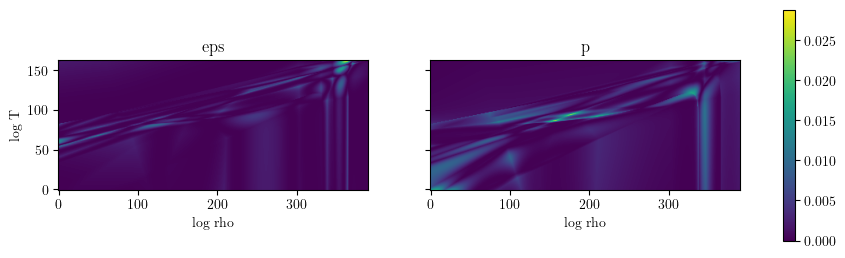

In [463]:
# Convert model to float
model = model.float()

# Target list
targets_list = [logenergy, logpress, np.log(cs2)]
titles_list = ["eps", "p", "cs2"]

# Initialize the plot
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(11,3))

# Choose the norm function to compare targets against predictions
norm_function = nnc2p.l2_norm

for i, ax in enumerate(axs):
    # Slice predictions
    sliced_predictions = predictions[:, i]
    values = targets_list[i]
    # Initialize v and zero the matrix
    targets = values[ye_index]
    targets = np.swapaxes(targets, 0, 1)
    print(targets.shape)
    # "Flatten" the array, but have to do it manually for some reason
    target_values = []
    for a in range(n_logtemp):
        for b in range(n_logrho):
            target_values.append(targets[b, a])
    target_values = np.array(target_values)
    delta_vals = norm_function(target_values, sliced_predictions, reduction=False)
    delta_vals = delta_vals.reshape((n_logtemp, n_logrho))
    # Then plot it
    im = ax.imshow(delta_vals, origin="lower") # norm=plt.colors.LogNorm(vmin=1e-9, vmax=1e0)
    ax.set_xlabel("log rho")
    if i == 0:
        ax.set_ylabel("log T")
    ax.set_title(titles_list[i])

cbar = fig.colorbar(im, ax=axs) # shrink=0.6
# cbar.ax.set_yscale('log')
plt.savefig(os.path.join(master_dir, "Plots/recovery_tabular_EOS.pdf"), bbox_inches='tight')
plt.show()

In [133]:
np.max(delta_vals)

0.09353939852511672

# Now, NNEOS with eps as input

__NNEOS__: try to replicate the EOS table (at least the core variables we are interested in) using the "input" variables logrho, logtemp, ye.

## Convert EOS table to table of training examples

In [202]:
# Get the filename of converted training data
filename = os.path.join(eos_tables_dir, "converted_eos_table.h5")

In [204]:
# # Create new dataset (if desired)
# # Specify output vars as "var_names" argument in this function - see physics.py
# eos_table = physics.read_eos_table(os.path.join(eos_tables_dir, eos_table_filename))
# physics.convert_eos_table(eos_table, save_name=filename)
# eos_table.close()

In [205]:
# Load the dataset afterwards
train_eos_table = h5py.File(filename, 'r')
# Get the data saved in the HDF5 file
logrho    = train_eos_table["logrho"][:]
logtemp   = train_eos_table["logtemp"][:]
ye        = train_eos_table["ye"][:]
logenergy = train_eos_table["logenergy"][:]
logpress  = train_eos_table["logpress"][:]
cs2       = train_eos_table["cs2"][:]
# Close the file
train_eos_table.close()

## Preprocess the data

### Delete negative $c_s^2$ values

There are apparently a few negative values for the speed of sound... They are likely a bug in the code? We'll remove them.

In [206]:
negative_indices = np.argwhere(cs2 < 0)
negative_indices

array([[3629826],
       [3629892],
       [3629958],
       [3630024],
       [3630090],
       [3630156],
       [3630222],
       [3630288],
       [3630354]], dtype=int64)

In [207]:
logrho    = np.delete(logrho, negative_indices, axis=0)
logtemp   = np.delete(logtemp, negative_indices, axis=0)
ye        = np.delete(ye, negative_indices, axis=0)
logenergy = np.delete(logenergy, negative_indices, axis=0)
logpress  = np.delete(logpress, negative_indices, axis=0)
cs2       = np.delete(cs2, negative_indices, axis=0)

### Use log values for $c_s^2$

Use ln-log for the cs2 values

In [208]:
logcs2 = np.log(cs2)

### Convert to Torch `Datasets` for training the network

Get into features and labels arrays

In [213]:
features = np.transpose(np.array([logrho, logtemp, ye]))
labels   = np.transpose(np.array([logpress, logenergy, logcs2]))

In [214]:
features

array([[ 3.02399601e+00, -3.00000000e+00,  5.00000000e-03],
       [ 3.02399601e+00, -3.00000000e+00,  1.50000000e-02],
       [ 3.02399601e+00, -3.00000000e+00,  2.50000000e-02],
       ...,
       [ 1.60239960e+01,  2.40000000e+00,  6.35000000e-01],
       [ 1.60239960e+01,  2.40000000e+00,  6.45000000e-01],
       [ 1.60239960e+01,  2.40000000e+00,  6.55000000e-01]])

In [215]:
labels.shape

(4206369, 3)

Get the training data as DataSet and DataLoader objects. Note on normalization: we fit transform on the training data, then use the fitted scaler object to transform (i.e. using same transformation as the training data) the test set.

In [216]:
# For normalization, use sklearn's StandardScaler
scaler = StandardScaler()
# Do train test split here
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
# "Cutoff": only use certain portion of the data for training and testing, to speed up training when tuning architecture 
cutoff = 0.025
print(len(train_features))
end = int(cutoff*len(train_features))
train_features = train_features[:end]
train_labels = train_labels[:end]
end = int(cutoff*len(test_features))
test_features = test_features[:end]
test_labels = test_labels[:end]
print(len(train_features))
# Convert to PyTorch Datasets as we defined them
train_dataset = data.HDF5Dataset(train_features, train_labels, normalization_function = scaler.fit_transform) 
test_dataset  = data.HDF5Dataset(test_features, test_labels, normalization_function = scaler.transform)
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size = 32)
test_dataloader  = DataLoader(test_dataset, batch_size = 32)

3154776
78869


### Training and inference

Create a new instance of the Net:

In [224]:
model = Net(nb_of_inputs=3, nb_of_outputs=3, h=[20, 20], activation_function=torch.nn.ReLU).double()

Or load from earlier:

In [225]:
# model = torch.load("../Models/tabeos_3_50_50_3.pt")
# test_input = [[1,1,1]]
# test_input = scaler.transform(test_input)
# test_input = torch.from_numpy(test_input).float()
# model(test_input)

In [226]:
print(scaler.mean_)
print(scaler.scale_)

[ 9.51608373 -0.30081866  0.32936217]
[3.76043372 1.56992791 0.19028245]


In [227]:
# model.state_dict()["linear1.bias"]

In [228]:
nnc2p.count_parameters(model)

563

Create a trainer object:

In [229]:
trainer = nnc2p.Trainer(model, 1e-2, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

Train the network

In [231]:
trainer.train(number_of_epochs = 1000)

Training the model for 1000 epochs.

 Epoch 0 
 --------------
Train loss: 4.06E-02
Test  loss: 4.06E-02

 Epoch 1 
 --------------
Train loss: 3.91E-02
Test  loss: 3.92E-02

 Epoch 2 
 --------------
Train loss: 4.17E-02
Test  loss: 4.19E-02

 Epoch 3 
 --------------
Train loss: 4.09E-02
Test  loss: 4.11E-02

 Epoch 4 
 --------------
Train loss: 4.10E-02
Test  loss: 4.12E-02

 Epoch 5 
 --------------
Train loss: 4.13E-02
Test  loss: 4.15E-02

 Epoch 6 
 --------------
Train loss: 4.31E-02
Test  loss: 4.34E-02

 Epoch 7 
 --------------
Train loss: 4.13E-02
Test  loss: 4.16E-02

 Epoch 8 
 --------------
Train loss: 4.20E-02
Test  loss: 4.23E-02

 Epoch 9 
 --------------
Train loss: 3.31E-02
Test  loss: 3.34E-02

 Epoch 10 
 --------------
Train loss: 3.12E-02
Test  loss: 3.14E-02

 Epoch 11 
 --------------
Train loss: 3.40E-02
Test  loss: 3.39E-02

 Epoch 12 
 --------------
Train loss: 3.69E-02
Test  loss: 3.68E-02

 Epoch 13 
 --------------
Train loss: 2.68E-02
Test  loss: 2.6

Train loss: 4.03E-03
Test  loss: 4.09E-03

 Epoch 116 
 --------------
Train loss: 4.01E-03
Test  loss: 4.08E-03

 Epoch 117 
 --------------
Train loss: 4.00E-03
Test  loss: 4.07E-03

 Epoch 118 
 --------------
Train loss: 4.01E-03
Test  loss: 4.07E-03

 Epoch 119 
 --------------
Train loss: 3.96E-03
Test  loss: 4.03E-03

 Epoch 120 
 --------------
Train loss: 3.93E-03
Test  loss: 4.00E-03

 Epoch 121 
 --------------
Train loss: 3.92E-03
Test  loss: 3.98E-03

 Epoch 122 
 --------------
Train loss: 3.88E-03
Test  loss: 3.95E-03

 Epoch 123 
 --------------
Train loss: 3.86E-03
Test  loss: 3.93E-03

 Epoch 124 
 --------------
Train loss: 3.84E-03
Test  loss: 3.90E-03

 Epoch 125 
 --------------
Train loss: 3.81E-03
Test  loss: 3.88E-03

 Epoch 126 
 --------------
Train loss: 3.80E-03
Test  loss: 3.87E-03

 Epoch 127 
 --------------
Train loss: 3.79E-03
Test  loss: 3.86E-03

 Epoch 128 
 --------------
Train loss: 3.76E-03
Test  loss: 3.83E-03

 Epoch 129 
 --------------
Train 

Train loss: 2.86E-03
Test  loss: 2.91E-03

 Epoch 231 
 --------------
Train loss: 2.85E-03
Test  loss: 2.90E-03

 Epoch 232 
 --------------
Train loss: 2.82E-03
Test  loss: 2.87E-03

 Epoch 233 
 --------------
Train loss: 2.81E-03
Test  loss: 2.86E-03

 Epoch 234 
 --------------
Train loss: 2.81E-03
Test  loss: 2.86E-03

 Epoch 235 
 --------------
Train loss: 2.81E-03
Test  loss: 2.86E-03

 Epoch 236 
 --------------
Train loss: 2.81E-03
Test  loss: 2.86E-03

 Epoch 237 
 --------------
Train loss: 2.80E-03
Test  loss: 2.85E-03

 Epoch 238 
 --------------
Train loss: 2.80E-03
Test  loss: 2.85E-03

 Epoch 239 
 --------------
Train loss: 2.79E-03
Test  loss: 2.84E-03

 Epoch 240 
 --------------
Train loss: 2.79E-03
Test  loss: 2.83E-03

 Epoch 241 
 --------------
Train loss: 2.78E-03
Test  loss: 2.83E-03

 Epoch 242 
 --------------
Train loss: 2.78E-03
Test  loss: 2.83E-03

 Epoch 243 
 --------------
Train loss: 2.78E-03
Test  loss: 2.82E-03

 Epoch 244 
 --------------
Train 

Adapting learning rate to 0.00015625
Train loss: 2.47E-03
Test  loss: 2.52E-03

 Epoch 346 
 --------------
Train loss: 2.48E-03
Test  loss: 2.53E-03

 Epoch 347 
 --------------
Train loss: 2.48E-03
Test  loss: 2.53E-03

 Epoch 348 
 --------------
Train loss: 2.48E-03
Test  loss: 2.53E-03

 Epoch 349 
 --------------
Train loss: 2.48E-03
Test  loss: 2.53E-03

 Epoch 350 
 --------------
Train loss: 2.48E-03
Test  loss: 2.53E-03

 Epoch 351 
 --------------
Train loss: 2.48E-03
Test  loss: 2.53E-03

 Epoch 352 
 --------------
Train loss: 2.48E-03
Test  loss: 2.53E-03

 Epoch 353 
 --------------
Train loss: 2.48E-03
Test  loss: 2.53E-03

 Epoch 354 
 --------------
Train loss: 2.48E-03
Test  loss: 2.53E-03

 Epoch 355 
 --------------
Train loss: 2.48E-03
Test  loss: 2.53E-03

 Epoch 356 
 --------------
Adapting learning rate to 7.8125e-05
Train loss: 2.48E-03
Test  loss: 2.53E-03

 Epoch 357 
 --------------
Train loss: 2.39E-03
Test  loss: 2.44E-03

 Epoch 358 
 --------------
Tra

Adapting learning rate to 1.52587890625e-07
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 456 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 457 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 458 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 459 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 460 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 461 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 462 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 463 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 464 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 465 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 466 
 --------------
Adapting learning rate to 7.62939453125e-08
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 467 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 468 
 ----

Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 565 
 --------------
Adapting learning rate to 1.4901161193847657e-10
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 566 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 567 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 568 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 569 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 570 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 571 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 572 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 573 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 574 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 575 
 --------------
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 576 
 --------------
Adapting learning rate to 7.450580596923828e-11
Train loss: 2.32E-03
Test  loss: 2.38E-03

 Epoch 5

KeyboardInterrupt: 

Save architecture if desired

In [46]:
os.getcwd()

'D:\\Thibeau\\master-thesis-AI\\Code'

In [232]:
# torch.save(model, "../Models/taboes_3_20_20_3_relu.pt")

In [233]:
# nnc2p.export_model("../Models/taboes_3_20_20_3_relu.pt", "../Models/paramvals_tabeos_final_20_relu")

Directory not found. Making new one at ../Models/paramvals_tabeos_final_20_relu
Succesfully exported model parameters to CSV file, at ../Models/paramvals_tabeos_final_20_relu


Report architecture (this saves info to a CSV, such as hidden layer set-up, nb of epochs trained, loss after training,... in order to compare performances across different architecture details).

In [31]:
# trainer.report_training("NNEOS_tab_experiments.csv", comment = "logeps, logpress and log cs2.")

Create a quick sketch of training

In [32]:
# plt.plot(trainer.train_losses, color='red', label="Train loss")
# plt.plot(trainer.test_losses, color='blue', label="Test loss")

# plt.grid()
# plt.legend()
# for ind in trainer.adaptation_indices:
#     plt.axvline(ind, ls = '--', color='grey')
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.ylabel("MSE Loss")
# plt.title("Training (50, 50) network tabular EOS for p and eps")
# plt.savefig("testing_training_tab_eos_network_50_50.pdf", bbox_inches = 'tight')
# plt.show()

### Load model after training

In case we have an already trained model, load it here. We have a network in `nn_tabeos_3_50_50_3.pth` (its state dict)

In [34]:
# state_dict = torch.load("nn_tabeos_3_50_50_3.pth")
# model.load_state_dict(state_dict)

<All keys matched successfully>

### Test the model

Get the errors on the different outputs, for different norms

In [252]:
l1.shape

(3,)

We will analyze the performance of the code in its accuracy as a function of the different domains. We fix the $Y_e$ value, and look at the error rates (absolute values) on the three as a function of log T and log rho.

In [142]:
# Fix a ye value here, can severely affect the results?
ye_index = len(ye) // 2
ye_value = ye[ye_index]
# Get the ranges
n_logrho, n_logtemp = targets.shape

Prepare the values to determine the accuracy:

In [143]:
# Get the values at this ye index: these are the "targets"
targets = logenergy[ye_index]
targets = np.swapaxes(targets, 0, 1)

Get the input values right

In [144]:
input_values = []
for logtemp_value in logtemp:
    for logrho_value in logrho:
        new_row = [logrho_value, logtemp_value, ye_value]
        input_values.append(new_row)
input_values = np.array(input_values)

Scaler transform & to tensor

In [147]:
input_values = scaler.transform(input_values)
input_values = torch.from_numpy(input_values).float()

In [148]:
with torch.no_grad():
    predictions = model(input_values)
    predictions = predictions.numpy()

In [149]:
predictions

array([[19.290712, 18.032537, 35.008884],
       [19.291523, 18.063354, 35.008648],
       [19.292202, 18.09436 , 35.008568],
       ...,
       [21.827118, 37.9868  , 48.73516 ],
       [21.876057, 38.07058 , 48.745255],
       [21.923769, 38.151787, 48.754364]], dtype=float32)

## Load and export model 

If desired, save the model

In [125]:
# torch.save(model, "nn_tabeos_3_50_50_3.pt")

If desired, load the original architecture (`tabular_eos_14_04.pth` contains for h = 50, 100, 20). 

In [124]:
# model = Net(nb_of_inputs=3, nb_of_outputs=3, h=[50, 50]).float()
# # Load the state dict
# state_dict = torch.load("nn_tabeos_3_50_50_3.pth") 
# # Convert everything to floats rather than doubles
# for key in state_dict:
#     state_dict[key] = state_dict[key].float()
# model.load_state_dict(state_dict)

<All keys matched successfully>

# Speed and timing tests: NN vs trilinear interpolation

## Compare performance against trilinear interpolation

In [29]:
# logcs2 = np.log(cs2)

In [30]:
# # Sample features and their labels
# n_samples = 10000
# sample_ind = np.random.choice(len(features), size=min(len(features), n_samples), replace=False)
# sample_features = features[sample_ind]
# sample_labels = labels[sample_ind]
# # Get predictions
# with torch.no_grad():
#     # Don't forget to apply normalization!!! We fixed the random seed for reproducibility
#     sample_features = scaler.transform(sample_features)
#     predictions = model(torch.from_numpy(sample_features).float())
#     predictions = predictions.numpy()
    
# # print(sample_labels[0])
# # print(predictions[0])
# print("L2       difference on sample: ", nnc2p.l2_norm(sample_labels, predictions))
# # print(nnc2p.l1_norm(sample_labels, predictions))
# print("Linfty difference on sample: ",nnc2p.linfty_norm(sample_labels, predictions))

Don't forget normalization (note: we can export the normalization procedure later on by saving the mean and std).

In [141]:
# print(f"Mean: {scaler.mean_}, std: {scaler.scale_}")

Mean: [ 9.51608373 -0.30081866  0.32936217], std: [3.76043372 1.56992791 0.19028245]


## Compare network with trilinear interpolation

We use scipy for the interpolation: see [this docs page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html#scipy.interpolate.interpn)

In [37]:
from scipy.interpolate import interpn

In [36]:
def randomn(a, b):
    """Generate a random number in the range [a, b]"""
    
    return a + (b-a)*np.random.rand()

We define our own trilinear interpolation routine based on scipy to replicate having to to interpn three times:

In [43]:
def trilinear_interpolation(points, values_list, test_points):
    """
    Does a single prediction using trilinear interpolation.
    """
    # Make the predictions
    predictions = np.zeros((len(test_points), len(values_list)))
    for i in range(len(values_list)):
        predictions[:, i] = interpn(points, values_list[i], test_points)
    # Return transpose: shape is (n_samples, n_vars) similar to neural network
    return predictions

For the grid points, we reverse the order compared to the EOS table. That is, the EOS table uses (ye, logtemp, logrho), but we will use (logrho, logtemp, ye).

In [33]:
logpress_reversed = np.swapaxes(logpress, 0, 2)
logenergy_reversed = np.swapaxes(logenergy, 0, 2)
logcs2_reversed = np.swapaxes(np.log(cs2), 0, 2)
print(logpress_reversed.shape)

(391, 163, 66)


C:\Users\thibe\AppData\Local\Temp\ipykernel_8344\1402824072.py:3: RuntimeWarning: invalid value encountered in log
  logcs2_reversed = np.swapaxes(np.log(cs2), 0, 2)


In [34]:
def sample_eos(logrho, logtemp, ye, n_examples = 1):
    """
    Simple auxiliary function that returns a random input data point for an EOS table, based on its (logrho, logtemp, ye) values.
    """
    
    return np.stack([[randomn(min(logrho), max(logrho)), randomn(min(logtemp), max(logtemp)), randomn(min(ye), max(ye))] for _ in range(n_examples)])

In [41]:
# Get an array of test cases:
n_examples = 10000
test_points = sample_eos(logrho, logtemp, ye, n_examples=n_examples)
# Grid of tables
points = (logrho, logtemp, ye)
# Variables we wish to get
values_list = [logenergy_reversed, logpress_reversed, logcs2_reversed]
# Interpolation
interpolated = trilinear_interpolation(points, values_list, test_points)
# print(interpolated)  # print in case n_examples is low
# Compare with neural net
with torch.no_grad():
    # Don't forget normalization!!!
    test_points_n = scaler.transform(test_points)
    model = model.float()
    predictions = model(torch.from_numpy(test_points_n).float())
    predictions = predictions.numpy()


Now get error rates

In [174]:
l1_error, l2_error, linfty_error = nnc2p.l1_norm(interpolated, predictions), nnc2p.l2_norm(interpolated, predictions), nnc2p.linfty_norm(interpolated, predictions)

In [175]:
print(l1_error)
print(l2_error)
print(linfty_error)

[0.00565407 0.0081235  0.01305064]
[5.65448465e-05 1.19128211e-04 7.66002332e-04]
[0.05040054 0.08126448 0.99801589]


## Compare performance of methods

Here, we will try to compare the performance of the methods, by measuring the time they take (CPU time) through `timeit`.

In [60]:
# # Get a single point that has to be predicted
test_point = sample_eos(logrho, logtemp, ye)

Choose the number of runs and number of loops within each run

In [61]:
n_runs = 10
n_loops = 10000

In [69]:
def time_execution(func, n_runs=10, n_loops=10000, verbose=True):
    # Save all the runtimes
    runtimes = []
    for _ in range(n_runs):
        # Start timer each run
        start = time.process_time_ns()
        for _ in range(n_loops):
            func()
        end = time.process_time_ns()
        # Convert to micro seconds and get average for one loop
        time_run = (end-start)/1000
        time_loop = time_run/n_loops
        runtimes.append(time_loop)
    
    # Convert to mean adn std
    mu, sigma = np.mean(runtimes), np.std(runtimes)
    
    if verbose:
        print(f"{mu} \pm {sigma} per loop ({n_runs} runs, {n_loops} each)")
    
    return mu, sigma

### Trilinear interpolation

Performance of trilinear interpolation with Scipy:

In [63]:
# Which values to predict?
values_list = [logenergy_reversed]
# single value:
val = logenergy_reversed
def function_interpn():
    [interpn(points, val, test_point) for val in values_list]

In [64]:
# %timeit -r10 -n10000 interpn(points, logenergy_reversed, test_point)  # measure Scipy

### Neural network (using PyTorch)

In [71]:
hidden_size = 10
act_func = torch.nn.ReLU
model = Net(nb_of_inputs=3, nb_of_outputs=3, h=[hidden_size, hidden_size], activation_function=act_func)

Performance of running the network with PyTorch built-ins: first convert point to right format

In [72]:
test_point_n = scaler.transform(test_point)
test_point_torch = torch.from_numpy(test_point_n).float()

In [73]:
def function_pytorch():
    model(test_point_torch)

### Neural network (using PyTorch, no grad)

It might be that saving the gradients etc in PyTorch can slow down the inference: check performance with grads disabled

In [74]:
def function_pytorch_no_grad():
    with torch.no_grad():
        model(test_point_torch)

### Neural network (using ONNX Runtime)

In [75]:
# def function4():
#     ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
#     ort_outs = ort_session.run(None, ort_inputs)

### Neural network (using Numpy)

Other comparison: the neural network but just the matrices and using Numpy! Save everything externally

In [77]:
test_point_np = test_point_n[0]

In [78]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [88]:
def relu(x):
    return np.maximum(x, 0, x)

In [89]:
def run_nn_sigmoid(x):
    x = np.matmul(w1, x) + b1
    x = sigmoid(x)
    x = np.matmul(w2, x) + b2
    x = sigmoid(x)
    x = np.matmul(w3, x)
    
    return x

In [90]:
def run_nn_relu(x):
    x = np.matmul(w1, x) + b1
    x = relu(x)
    x = np.matmul(w2, x) + b2
    x = relu(x)
    x = np.matmul(w3, x)
    
    return x

In [80]:
# # Check if we get the same results -- OK
# print(test_point)
# test1 = run_nn(test_point[0])
# print(test1)
# with torch.no_grad():
#     test2 = model(torch.from_numpy(test_point[0]).float())
#     test2 = test2.numpy()
# print(test2)

In [91]:
def function_numpy_sigmoid():
    run_nn_sigmoid(test_point_np)
def function_numpy_relu():
    run_nn_relu(test_point_np)

### Python (no packages) -- DEPRECATED

Convert everything to lists

In [191]:
# test_point_list = test_point_np.tolist()
# test_point_list = [[val] for val in test_point_list]
# print(test_point_list)
# w1_list = w1.tolist()
# # b1_list = b1.tolist()
# b1_list = [[b1[i]] for i in range(len(b1))]
# # b1_list = [b1_list]
# w2_list = w2.tolist()
# b2_list = [[b2[i]] for i in range(len(b2))]
# w3_list = w3.tolist()

[[0.5463538641652405], [0.09203259199418481], [-1.280980106027008]]


Get sigmoid function without numpy

In [192]:
# def sigmoid_list(x):
#     return [[1/(1+2.71828182845904523536028747135266249**(-x[i][0]))] for i in range(len(x))]

In [193]:
# def mm(A, B):
#     """Matrix multiplication, pure Python"""
#     return [[sum(a*b for a,b in zip(A_row, B_col)) for B_col in zip(*B)] for A_row in A]

In [194]:
# a = [[2, 0, 0], [0, 2, 0], [0, 0, 2]]
# b = [[1],[2],[3]]
# first = mm(a,b)
# print(first)
# second = sigmoid_list(b)
# [[first[i][0] + second[i][0]] for i in range(len(first))]

[[2], [4], [6]]


[[2.731058578630005], [4.880797077977882], [6.952574126822433]]

In [195]:
# def run_nn_list(x):
#     x = mm(w1_list, x)
#     x = [[x[i][0] + b1_list[i][0]] for i in range(len(x))]
#     x = sigmoid_list(x)
#     x = mm(w2_list, x)
#     x = [[x[i][0] + b2_list[i][0]] for i in range(len(x))]
#     x = sigmoid_list(x)
#     x = mm(w3_list, x)
    
#     return x

The shape is slightly different, but this is good enough!

In [196]:
# # Check if we get the same results -- OK
# test1 = run_nn_list(test_point_list)
# print(test1)
# with torch.no_grad():
#     test2 = model(test_point_torch)
#     test2 = test2.numpy()
# print(test2)

[[19.28380190064578], [29.502848125783046], [41.66890742358023]]
[[19.283802 29.50285  41.668907]]


In [58]:
# def function6():
#     run_nn_list(test_point_list)

## Perform the analysis

In [82]:
# Define new model and take care of it
hidden_size = 10
act_func = torch.nn.ReLU
model = Net(nb_of_inputs=3, nb_of_outputs=3, h=[hidden_size, hidden_size], activation_function=act_func)

w1 = model.state_dict()["linear1.weight"].numpy()
b1 = model.state_dict()["linear1.bias"].numpy()
w2 = model.state_dict()["linear2.weight"].numpy()
b2 = model.state_dict()["linear2.bias"].numpy()
w3 = model.state_dict()["linear3.weight"].numpy()

__Do the runtime analysis__

In [85]:
# Empty lists
mu_list, sigma_list = [], []
# Functions & names for runtime analysis
funcs = [function_interpn, function_pytorch, function_pytorch_no_grad, function_numpy] # 
method_names = ["Interpolation", "PyTorch", "PyTorch (no grad)", "Numpy"] # 
for i, func in enumerate(funcs):
    print(f"--- {method_names[i]} ---")
    mu, sigma = time_execution(func)
    mu_list.append(mu)
    sigma_list.append(sigma)

--- Interpolation ---
251.09375 \pm 5.9313290300319705 per loop (10 runs, 10000 each)
--- PyTorch ---
104.0625 \pm 3.9031237489989987 per loop (10 runs, 10000 each)
--- PyTorch (no grad) ---
53.4375 \pm 10.265042316035526 per loop (10 runs, 10000 each)
--- Numpy ---
10.78125 \pm 3.3838137230793306 per loop (10 runs, 10000 each)


In [86]:
speedup = round(mu_list[0]/mu_list[-1])
print(f"Best neural net implementation is around {speedup}x faster.")

Best neural net implementation is around 23x faster.


## Performance for NN architectures

In [100]:
hidden_size_list = [10, 20, 50]
act_func_list = [torch.nn.ReLU, torch.nn.Sigmoid]

mu_dict = {"Hidden size": [], "Act func": [], "Method": [], "Result": []}
sigma_dict = {"Hidden size": [], "Act func": [], "Method": [], "Result": []}
funcs = [function_pytorch, function_pytorch_no_grad, function_numpy]

for hidden_size in hidden_size_list:
    for act_func in act_func_list:
        # Define new model and take care of it
        print(f"Hidden size: {hidden_size}. Act func: {act_func}")
        if act_func == torch.nn.Sigmoid:
            act_func_name = "Sigmoid"
            print(act_func_name)
            function_numpy = function_numpy_sigmoid
        else:
            act_func_name = "ReLU"
            print(act_func_name)
            function_numpy = function_numpy_relu
        # Define the model
        model = Net(nb_of_inputs=3, nb_of_outputs=3, h=[hidden_size, hidden_size], activation_function=act_func)
        # Get the matrices, for the numpy implementation
        w1 = model.state_dict()["linear1.weight"].numpy()
        b1 = model.state_dict()["linear1.bias"].numpy()
        w2 = model.state_dict()["linear2.weight"].numpy()
        b2 = model.state_dict()["linear2.bias"].numpy()
        w3 = model.state_dict()["linear3.weight"].numpy()
        # Functions & names for runtime analysis
        
        method_names = ["PyTorch", "PyTorch (no grad)", "Numpy"] # 
        for i, func in enumerate(funcs):
            print(f"--- {method_names[i]} ---")
            mu, sigma = time_execution(func)
            # Append everything
            mu_dict["Hidden size"].append(hidden_size)
            mu_dict["Act func"].append(act_func_name)
            mu_dict["Method"].append(method_names[i])
            mu_dict["Result"].append(mu)
            sigma_dict["Hidden size"].append(hidden_size)
            sigma_dict["Act func"].append(act_func_name)
            sigma_dict["Method"].append(method_names[i])
            sigma_dict["Result"].append(sigma)

Hidden size: 10. Act func: <class 'torch.nn.modules.activation.ReLU'>
ReLU
--- PyTorch ---
99.84375 \pm 5.387793640489583 per loop (10 runs, 10000 each)
--- PyTorch (no grad) ---
69.21875 \pm 3.2059819576067485 per loop (10 runs, 10000 each)
--- Numpy ---
18.28125 \pm 1.0004881620988826 per loop (10 runs, 10000 each)
Hidden size: 10. Act func: <class 'torch.nn.modules.activation.Sigmoid'>
Sigmoid
--- PyTorch ---
96.25 \pm 2.724311839712921 per loop (10 runs, 10000 each)
--- PyTorch (no grad) ---
66.71875 \pm 3.0498783274911148 per loop (10 runs, 10000 each)
--- Numpy ---
17.96875 \pm 1.4405538214520137 per loop (10 runs, 10000 each)
Hidden size: 20. Act func: <class 'torch.nn.modules.activation.ReLU'>
ReLU
--- PyTorch ---
105.78125 \pm 3.6342822967540647 per loop (10 runs, 10000 each)
--- PyTorch (no grad) ---
72.03125 \pm 3.5251606789620245 per loop (10 runs, 10000 each)
--- Numpy ---
18.125 \pm 1.0364452469860626 per loop (10 runs, 10000 each)
Hidden size: 20. Act func: <class 'torch

### Analysis

In [127]:
fs = 16

Comparison of hidden sizes and activation functions

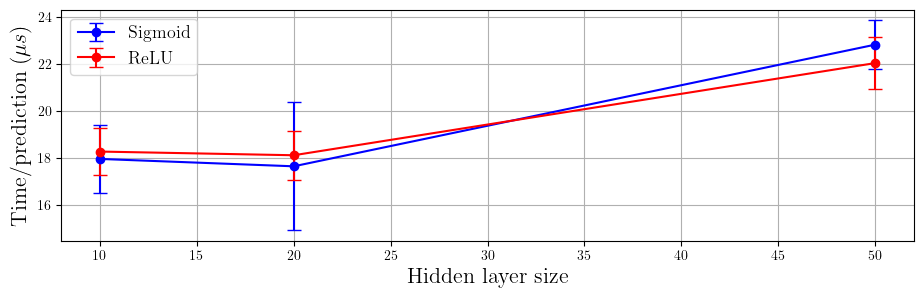

In [130]:
# Select which inference method to check
choice = "Numpy"

# Load data
mu_df = pd.DataFrame.from_dict(mu_dict)
sigma_df = pd.DataFrame.from_dict(sigma_dict)
# Limit to one choice
mu_df = mu_df[mu_df["Method"] == choice]
sigma_df = sigma_df[sigma_df["Method"] == choice]
# Get vals
hidden_size_list = np.unique(mu_df["Hidden size"].values)

plt.figure(figsize = (11,3))
names = ["Sigmoid", "ReLU"]
colors = ["blue", "red"]
for i, name in enumerate(names):
    y = mu_df[mu_df["Act func"] == name]["Result"]
    yerr = sigma_df[sigma_df["Act func"] == name]["Result"]
    plt.errorbar(hidden_size_list, y, yerr = yerr, fmt = '-o', color=colors[i], capsize=5, label = name)
plt.legend(fontsize=fs-3)
plt.grid()
plt.xlabel(r"Hidden layer size", fontsize=fs)
plt.ylabel(r"Time/prediction ($\mu s$)", fontsize=fs)
plt.show()

Comparison of different methods

In [180]:
mu_df    = pd.DataFrame.from_dict(mu_dict)
sigma_df = pd.DataFrame.from_dict(sigma_dict)
# Limit to one choice
act_func = "ReLU"
hidden = 20
mu_df = mu_df[((mu_df["Act func"] == act_func) & (mu_df["Hidden size"] == hidden))]
sigma_df = sigma_df[((sigma_df["Act func"] == act_func) & (sigma_df["Hidden size"] == hidden))]
mu_df["Sigma"] = sigma_df["Result"]
mu_df.drop(["Hidden size", "Act func"], axis=1, inplace=True)
mu_df

,Method,Result,Sigma
6,PyTorch,105.78125,3.634282
7,PyTorch (no grad),72.03125,3.525161
8,Numpy,18.12500,1.036445


In [181]:
print(mu_df.to_latex())

\begin{tabular}{llrr}
\toprule
{} &             Method &     Result &     Sigma \\
\midrule
6 &            PyTorch &  105.78125 &  3.634282 \\
7 &  PyTorch (no grad) &   72.03125 &  3.525161 \\
8 &              Numpy &   18.12500 &  1.036445 \\
\bottomrule
\end{tabular}



C:\Users\thibe\AppData\Local\Temp\ipykernel_8344\1619524569.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(mu_df.to_latex())


Interpolation was: 251.09 \pm 5.93

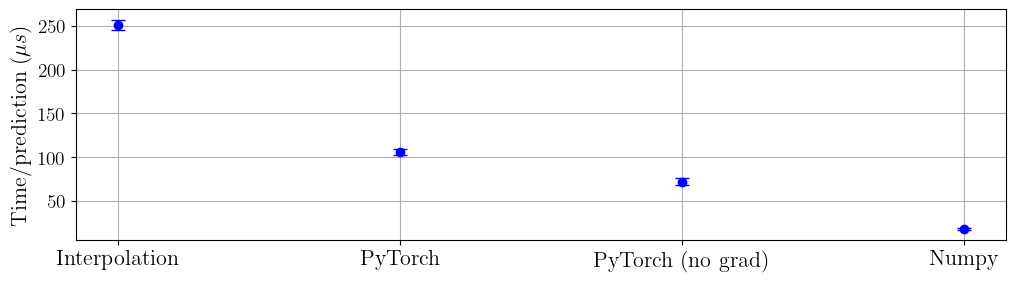

In [178]:
# # Select which inference method to check
# # choice = "Numpy"
# act_func = "ReLU"
# hidden = 20
# # Load data
# mu_df = pd.DataFrame.from_dict(mu_dict)
# sigma_df = pd.DataFrame.from_dict(sigma_dict)
# # Limit to one choice

# mu_df = mu_df[((mu_df["Act func"] == act_func) & (mu_df["Hidden size"] == hidden))]
# sigma_df = sigma_df[((sigma_df["Act func"] == act_func) & (sigma_df["Hidden size"] == hidden))]
# # Get vals
# hidden_size_list = np.unique(mu_df["Hidden size"].values)

# plt.figure(figsize = (12, 3))
# y    = mu_df[((mu_df["Act func"] == act_func) & (mu_df["Hidden size"] == hidden))]["Result"]
# yerr = sigma_df[((sigma_df["Act func"] == act_func) & (sigma_df["Hidden size"] == hidden))]["Result"]

# plt.errorbar([0], [251.09375], yerr = [5.931], fmt = 'o', color="blue", capsize=5, label = name)
# plt.errorbar([1,2,3], y, yerr = yerr, fmt = 'o', color="blue", capsize=5, label = name)
# plt.xticks([0,1,2,3], labels = ["Interpolation", "PyTorch", "PyTorch (no grad)", "Numpy"], rotation = 0, fontsize=fs)
# plt.yticks(fontsize=fs-2)
# plt.grid()
# plt.ylabel(r"Time/prediction ($\mu s$)", fontsize=fs)
# plt.show()

# Export model params to replicate the analysis in Fortran

In [509]:
act_func_names = ["sigmoid", "relu"]
hidden_size_list = [20, 50, 70]
hidden_size_list = [10, 20, 50]
for hidden_size in hidden_size_list:
    for i, act_func in enumerate(act_func_list):
        model = Net(nb_of_inputs=3, nb_of_outputs=3, h=[hidden_size, hidden_size], activation_function=act_func)
        print(nnc2p.count_parameters(model))
        # Export the model
        torch.save(model, "../Models/ignore_me.pt")
        save_name = f"../Models/paramvals_tabeos_single_{hidden_size}_{act_func_names[i]}"
        nnc2p.export_model("../Models/ignore_me.pt", save_name)

183
Directory not found. Making new one at ../Models/paramvals_tabeos_single_10_sigmoid
Succesfully exported model parameters to CSV file, at ../Models/paramvals_tabeos_single_10_sigmoid
183
Directory not found. Making new one at ../Models/paramvals_tabeos_single_10_relu
Succesfully exported model parameters to CSV file, at ../Models/paramvals_tabeos_single_10_relu
563
Succesfully exported model parameters to CSV file, at ../Models/paramvals_tabeos_single_20_sigmoid
563
Succesfully exported model parameters to CSV file, at ../Models/paramvals_tabeos_single_20_relu
2903
Succesfully exported model parameters to CSV file, at ../Models/paramvals_tabeos_single_50_sigmoid
2903
Succesfully exported model parameters to CSV file, at ../Models/paramvals_tabeos_single_50_relu


Results will be recorded here:
- sigmoid
- relu_max, implemented with max function
- relu, standard implementation

## Measure speeds

Wrong: these are for 3 predictions in a row but we have to compare against a single prediction

In [183]:
# fortran_interpolation = np.array([1.1943418979644774e-6, \
#                                   1.2492423057556153e-6, \
#                                   1.4265980124473571e-6, \
#                                   1.1522794961929322e-6, \
#                                   1.3419776558876037e-6, \
#                                   1.2229737639427184e-6, \
#                                   1.2357207536697389e-6, \
#                                   1.1515803337097169e-6, \
#                                   1.1628186106681824e-6, \
#                                   1.1426681280136109e-6, \
#                                   1.1674029231071473e-6, \
#                                   1.1869792342185975e-6, \
#                                   1.2122482657432556e-6, \
#                                   1.2581764459609986e-6, \
#                                   1.2601274251937866e-6, \
#                                   1.2311937808990478e-6, \
#                                   1.3119986057281493e-6, \
#                                   1.2949457168579102e-6, \
#                                   1.3183966875076295e-6, \
#                                   1.1574876308441161e-6, \
#                                   1.2880070209503174e-6
#                                  ])

These are for interpolation predicting only one column:

In [496]:
fortran_interpolation = np.array([8.4825992584228511e-7, \
                                  8.2161378860473635e-7, \
                                  8.7507796287536619e-7, \
                                  8.5263025760650636e-7, \
                                  9.0884041786193846e-7, \
                                  9.2787605524063105e-7, \
                                  8.3888393640518191e-7, \
                                  8.0844181776046748e-7, \
                                  7.9883116483688353e-7, \
                                  8.3878827095031742e-7, \
                                  8.0311286449432373e-7
                                 ])

In [492]:
fortran_sigmoid       = {10: [9.3441748619079588e-7, \
                              9.2670011520385738e-7, \
                              9.2636156082153317e-7, \
                              8.8198614120483396e-7, \
                              9.2840200662612914e-7, \
                              8.9005309343338012e-7, \
                              9.2985749244689940e-7, \
                              8.8784492015838626e-7, \
                              8.7760967016220088e-7, \
                              8.7397480010986333e-7, \
                              8.8543587923049932e-7], 
                         20: [1.2631109356880188e-6, \
                              1.3248761892318727e-6, \
                              1.2622952461242677e-6, \
                              1.3545445203781128e-6, \
                              1.2575612068176268e-6, \
                              1.1978712081909180e-6, \
                              1.2112507820129394e-6, \
                              1.2595268487930299e-6, \
                              1.2371557950973510e-6, \
                              1.3366787433624267e-6
                             ],
                         50: [2.9304871559143067e-6, \
                              2.7196670174598695e-6, \
                              2.5697495937347413e-6, \
                              2.6253808140754702e-6, \
                              2.5486350655555724e-6, \
                              2.6479148268699645e-6, \
                              2.6181338429450987e-6, \
                              2.5736796855926515e-6, \
                              2.5205017328262330e-6, \
                              2.5094261169433596e-6                             
                         ]
                        }

fortran_relu_max      = {10: [7.3742908239364624e-7, \
                              7.4901795387268063e-7, \
                              7.7237284183502198e-7, \
                              7.5893640518188474e-7, \
                              7.9469406604766843e-7, \
                              7.7821362018585203e-7, \
                              8.4216290712356567e-7, \
                              7.7764701843261717e-7, \
                              7.5764548778533941e-7, \
                              7.6082623004913326e-7
                             ],
                        20: [9.5538818836212154e-7, \
                             9.8768472671508782e-7, \
                             9.7171586751937859e-7, \
                             9.6920156478881842e-7, \
                             9.4863593578338618e-7, \
                             1.0146088004112243e-6, \
                             9.3995338678359981e-7, \
                             9.4664561748504638e-7, \
                             9.4261842966079711e-7, \
                             9.3299466371536254e-7
                            ],
                        50: [1.7813495397567748e-6, \
                             1.8087434172630310e-6, \
                             1.8768922090530395e-6, \
                             1.8062906265258790e-6, \
                             1.7930529117584229e-6, \
                             1.8185124397277832e-6, \
                             1.8465325832366944e-6, \
                             1.7979505062103272e-6, \
                             1.7861731052398682e-6, \
                             1.8594285845756530e-6
                            ]}

fortran_relu          = {10: [7.4908113479614259e-7, \
                              7.5351035594940190e-7, \
                              7.5944864749908447e-7, \
                              7.6549577713012697e-7, \
                              7.7743101119995114e-7, \
                              7.6206517219543459e-7, \
                              7.5476324558258061e-7, \
                              7.5979411602020264e-7, \
                              7.7378511428833013e-7, \
                              7.4373769760131835e-7
                             ],
                        20: [9.4275051355361941e-7, \
                             9.6708679199218757e-7, \
                             9.6439296007156381e-7, \
                             9.8073935508728031e-7, \
                             1.0076233744621276e-6, \
                             9.8190152645111080e-7, \
                             1.0246781110763550e-6, \
                             1.0190943479537964e-6, \
                             9.9296319484710702e-7, \
                             9.6782040596008292e-7
                            ],
                        50: [2.0380783081054688e-6, \
                             1.8350322842597962e-6, \
                             1.8680638074874878e-6, \
                             1.8157511353492737e-6, \
                             1.9213995933532717e-6, \
                             1.8739464282989501e-6, \
                             1.7961593866348267e-6, \
                             1.8243160247802734e-6, \
                             1.8296554088592529e-6, \
                             1.8083146810531616e-6
                            ]}

Single layer:

In [497]:
fortran_sigmoid_single = {20: [8.8422411680221555e-7, \
                               9.2766052484512329e-7, \
                               9.0931558609008790e-7, \
                               9.2620706558227536e-7, \
                               9.3423449993133547e-7, \
                               9.2991966009140019e-7, \
                               9.5376998186111459e-7, \
                               9.1550111770629883e-7, \
                               9.5793610811233529e-7, \
                               8.7101125717163087e-7
                              ],
                         50: [1.3135874867439269e-6, \
                              1.2462930679321288e-6, \
                              1.2182465195655822e-6, \
                              1.3025012016296386e-6, \
                              1.3376687765121459e-6, \
                              1.2974005937576295e-6, \
                              1.4645587205886840e-6, \
                              1.3120357990264893e-6, \
                              1.3318451046943665e-6, \
                              1.3591961860656738e-6
                             ],
                         70: [1.4925893545150757e-6, \
                              1.5304015278816223e-6, \
                              1.5216457247734070e-6, \
                              1.5077395439147949e-6, \
                              1.5441306829452514e-6, \
                              1.6862218379974365e-6, \
                              1.5267245173454285e-6, \
                              1.6295769214630126e-6, \
                              1.4693150520324706e-6, \
                              1.4698832035064696e-6
                             ]}

fortran_relu_single = {20: [7.4636149406433103e-7, \
                            7.5247341394424438e-7, \
                            7.5171309709548953e-7, \
                            7.8268545866012572e-7, \
                            7.4827289581298829e-7, \
                            7.4540895223617551e-7, \
                            7.5198465585708616e-7, \
                            7.6176834106445316e-7, \
                            7.4094623327255251e-7, \
                            7.7116000652313231e-7
                           ],
                      50: [9.2674583196640019e-7, \
                           9.5915114879608147e-7, \
                           9.3898320198059085e-7, \
                           9.0106201171875000e-7, \
                           8.8890844583511351e-7, \
                           8.7947177886962894e-7, \
                           8.9343988895416255e-7, \
                           8.9994609355926512e-7, \
                           9.1378533840179443e-7, \
                           9.1908794641494748e-7, \
                           8.9844727516174318e-7
                          ],
                      70: [1.0014158487319946e-6, \
                           1.1096044778823853e-6, \
                           9.9048733711242668e-7, \
                           1.0040555596351624e-6, \
                           9.7174286842346186e-7, \
                           9.9844294786453252e-7, \
                           9.6122008562088014e-7, \
                           9.9813699722290040e-7, \
                           9.9091988801956185e-7, \
                           9.8674577474594109e-7
                          ]}

## Analyze speeds

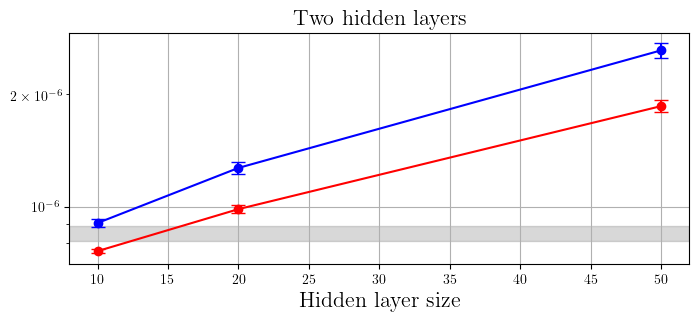

In [516]:
plt.figure(figsize = (8, 3))
fortran_timings = [fortran_sigmoid, fortran_relu] # fortran_relu_max
sizes = [10, 20, 50]
colors = ["blue", "red", "green"]
names = ["Sigmoid", "ReLU", "ReLU (max)"]

for i, timing in enumerate(fortran_timings):
    x    = sizes
    y    = []
    yerr = []
    for s in sizes:
        y.append(np.mean(timing[s]))
        yerr.append(np.std(timing[s]))
    plt.errorbar(x, y, yerr = yerr, fmt = '-o', color=colors[i], capsize=5, label = names[i])
# Shade the baseline determined by the linear interpolation methods
mu = np.mean(fortran_interpolation)
sigma = np.std(fortran_interpolation)
lower_bound = mu - sigma
upper_bound = mu + sigma
plt.axhspan(lower_bound, upper_bound, alpha=0.3, color='gray', label='Interpolation')
# plt.legend(fontsize=fs-3)
plt.grid()
plt.yscale('log')
plt.title("Two hidden layers", fontsize=fs)
plt.xlabel(r"Hidden layer size", fontsize=fs)
# plt.ylabel(r"Time/prediction ($\mu s$)", fontsize=fs)
plt.savefig("../Plots/Final/nneos_timing_measurements_fortran.pdf", bbox_inches='tight')
plt.show()

<Figure size 800x300 with 0 Axes>

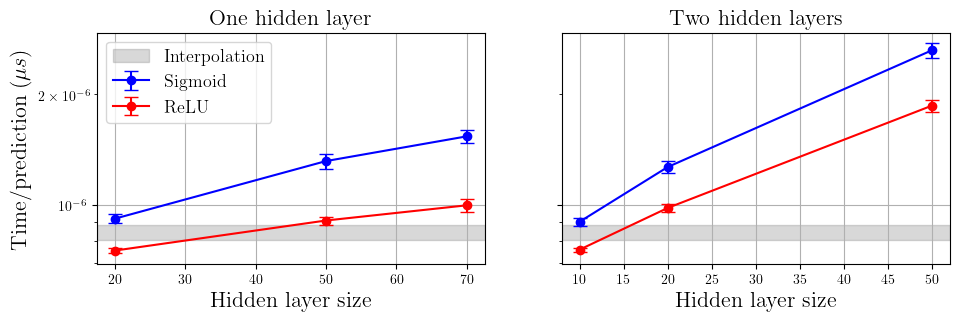

In [524]:
plt.figure(figsize = (8, 3))
fortran_timings = [fortran_sigmoid, fortran_relu] # fortran_relu_max
fortran_timings_single = [fortran_sigmoid_single, fortran_relu_single] # fortran_relu_max
sizes_single = [20, 50, 70]
sizes = [10, 20, 50] 
colors = ["blue", "red", "green"]
names = ["Sigmoid", "ReLU", "ReLU (max)"]

# Shade the baseline determined by the linear interpolation methods
mu = np.mean(fortran_interpolation)
sigma = np.std(fortran_interpolation)
lower_bound = mu - sigma
upper_bound = mu + sigma

fig, axs = plt.subplots(1, 2, figsize=(11,3), sharey=True)
ax1, ax2 = axs

for ax in axs:
    if ax == ax1:
        timings = fortran_timings_single
        size_list = sizes_single
        ax.set_ylabel(r"Time/prediction ($\mu s$)", fontsize=fs)
        ax.set_title("One hidden layer", fontsize=fs)
    else:
        timings = fortran_timings
        size_list = sizes
        ax.set_title("Two hidden layers", fontsize=fs)
    for i, timing in enumerate(timings):
        x    = size_list
        y    = []
        yerr = []
        for s in size_list:
            y.append(np.mean(timing[s]))
            yerr.append(np.std(timing[s]))
        ax.errorbar(x, y, yerr = yerr, fmt = '-o', color=colors[i], capsize=5, label = names[i])
    # Shared:
    ax1.legend(fontsize=fs-3, loc="upper left")
    ax.grid()
    ax.set_xlabel(r"Hidden layer size", fontsize=fs)

    ax.axhspan(lower_bound, upper_bound, alpha=0.3, color='gray', label='Interpolation')
    ax.set_yscale('log')

plt.savefig("../Plots/Final/nneos_timing_measurements_fortran_both.pdf", bbox_inches='tight')
plt.show()

For the report:

In [506]:
print(np.mean(fortran_relu[20]))

9.84905058145523e-07


What if it is in terms of nb of params?

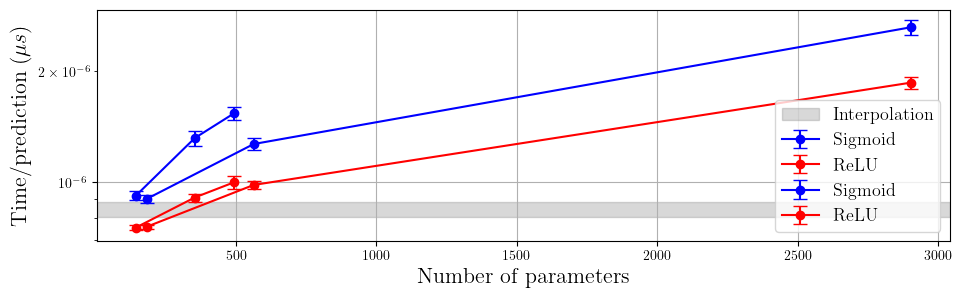

In [513]:
plt.figure(figsize = (11, 3))
fortran_timings = [fortran_sigmoid_single, fortran_relu_single] # fortran_relu_max

colors = ["blue", "red", "green"]
names = ["Sigmoid", "ReLU", "ReLU (max)"]

## Single
sizes = [20, 50, 70]
for i, timing in enumerate([fortran_sigmoid_single, fortran_relu_single]):
    x    = [143, 353, 493]
    y    = []
    yerr = []
    for s in sizes:
        y.append(np.mean(timing[s]))
        yerr.append(np.std(timing[s]))
    plt.errorbar(x, y, yerr = yerr, fmt = '-o', color=colors[i], capsize=5, label = names[i])
    
## Double
sizes = [10, 20, 50]
for i, timing in enumerate([fortran_sigmoid, fortran_relu]):
    x    = [183, 563, 2903]
    y    = []
    yerr = []
    for s in sizes:
        y.append(np.mean(timing[s]))
        yerr.append(np.std(timing[s]))
    plt.errorbar(x, y, yerr = yerr, fmt = '-o', color=colors[i], capsize=5, label = names[i])
    
# Shade the baseline determined by the linear interpolation methods
mu = np.mean(fortran_interpolation)
sigma = np.std(fortran_interpolation)
lower_bound = mu - sigma
upper_bound = mu + sigma
plt.axhspan(lower_bound, upper_bound, alpha=0.3, color='gray', label='Interpolation')
plt.legend(fontsize=fs-3)
plt.grid()
plt.yscale('log')
plt.xlabel(r"Number of parameters", fontsize=fs)
plt.ylabel(r"Time/prediction ($\mu s$)", fontsize=fs)
# plt.savefig("../Plots/Final/nneos_timing_measurements_fortran_single.pdf", bbox_inches='tight')
plt.show()

In [209]:
# cutoff = 5

# # Get vals more clearly, do cutoff
# xvals = xticks[:cutoff]
# yvals = mu_list[:cutoff]
# yerrs = sigma_list[:cutoff]
# # Swap based on performance  ## NOT WORKING FOR SOME REASON
# # sort_ind = np.argsort(yvals)[::-1]
# # # Sort
# # xvals = my_sort(xvals, sort_ind)
# # yvals = my_sort(yvals, sort_ind)
# # yerrs = my_sort(yerrs, sort_ind)
# # method_names = my_sort(method_names, sort_ind)

In [131]:
# # Preparation
# plt.errorbar(xticks, yvals, yerrs, fmt="o", color="blue", capsize=5)
# plt.xticks(ticks=xticks, labels = method_names, rotation=30)
# plt.ylabel("CPU time/prediction (µs)")
# plt.grid()
# plt.savefig("Time comparison single prediction")
# # plt.savefig("interpolation_neuralnet_speed_comparison.pdf", bbox_inches='tight')
# plt.show()

# Second goal: NNC2P

__TO DO__ think about design of architecture AND fix the conserved variable values -- I think they were not computed correctly before! 

__NNC2P__: try to replicate the full C2P conversion.

Generate training data through sampling and looking-up in the table. Save/load from our eos tables dir, where all (too large) datasets related to the EOS tables are saved to.

In [83]:
print(eos_tables_dir)

D:/Coding/Datasets/eos_tables


Construct datasets if desired

In [90]:
# # Open EOS table
# eos_table = physics.read_eos_table(os.path.join(eos_tables_dir, eos_table_filename))
# physics.generate_c2p_data_tabular_eos(eos_table, number_of_points=100000, save_name=os.path.join(eos_tables_dir, "train_c2p_data.h5"))
# eos_table.close()

Load in the dataset afterwards

In [91]:
# Load the dataset afterwards
train_c2p_table = h5py.File(os.path.join(eos_tables_dir, "train_c2p_data.h5"), 'r')
# Get the data saved in the HDF5 file for training
# NOTE have to convert to float not double, otherwise PyTorch gives an error
features = train_c2p_table["features"][:].astype(np.float32)
labels = train_c2p_table["labels"][:].astype(np.float32)
# # See what's in there
# for key in train_c2p_table:
#     print(key)

# Close the file
train_c2p_table.close()

Explore this dataset

In [92]:
print("Min of input")
print(np.min(features, axis=0))
print("Max of input")
print(np.max(features, axis=0))
print("---")
print("Min of output")
print(np.min(labels, axis=0))
print("Max of output")
print(np.max(labels, axis=0))

Min of input
[3.0239964e+00 1.9037802e+01 2.2053352e+01 4.9999999e-03]
Max of input
[16.18306  38.488518 38.472675  0.655   ]
---
Min of output
[17.457466]
Max of output
[38.162045]


### Convert to Torch `Datasets` for training the network

Get the training data as DataSet and DataLoader objects. Note on normalization: we fit transform on the training data, then use the fitted scaler object to transform (i.e. using same transformation as the training data) the test set.

In [95]:
# For normalization, use sklearn's StandardScaler
scaler = StandardScaler()
# Do train test split here
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
# "Cutoff": only use certain portion of the data for training and testing, to speed up training when tuning architecture 
# Note - our sampling procedure above guarantees we can ignore the cutoff, unlike the NNEOS code above which had 4 million datapoints in total
cutoff = 1
print(f"Size training data: {len(train_features)}")
print(f"Size testing data: {len(test_features)}")
end = int(cutoff*len(train_features))
train_features = train_features[:end]
train_labels = train_labels[:end]
end = int(cutoff*len(test_features))
test_features = test_features[:end]
test_labels = test_labels[:end]
print(f"Size training data (cutoff): {len(train_features)}")
# Convert to PyTorch Datasets as we defined them
train_dataset = data.HDF5Dataset(train_features, train_labels, normalization_function = scaler.fit_transform) 
test_dataset  = data.HDF5Dataset(test_features, test_labels, normalization_function = scaler.transform)
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size = 32)
test_dataloader  = DataLoader(test_dataset, batch_size = 32)

Size training data: 75000
Size testing data: 25000
Size training data (cutoff): 75000


Get the scaler's attributes: 

In [96]:
print(f"Scaler mean: {scaler.mean_}, \n Scaler std: {scaler.scale_}")

Scaler mean: [ 9.58863041 30.23533938 30.7298278   0.3288648 ], 
 Scaler std: [3.76007097 4.0125932  3.91964587 0.1902224 ]


### Archive

Create a new instance of the Net:

In [105]:
model = Net(nb_of_inputs = 4, nb_of_outputs = 1, h=[600, 200], activation_function=torch.nn.ReLU)
model = model.float()

In [106]:
nnc2p.count_parameters(model)

123400

Create a trainer object from it:

In [110]:
trainer = nnc2p.Trainer(model, 1e-3, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [ ]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 5.70E-02
Test  loss: 5.92E-02

 Epoch 1 
 --------------
Train loss: 5.69E-02
Test  loss: 5.90E-02

 Epoch 2 
 --------------
Train loss: 5.66E-02
Test  loss: 5.87E-02

 Epoch 3 
 --------------
Train loss: 5.64E-02
Test  loss: 5.85E-02

 Epoch 4 
 --------------
Train loss: 5.63E-02
Test  loss: 5.84E-02

 Epoch 5 
 --------------
Train loss: 5.63E-02
Test  loss: 5.83E-02

 Epoch 6 
 --------------
Train loss: 5.61E-02
Test  loss: 5.81E-02

 Epoch 7 
 --------------
Train loss: 5.59E-02
Test  loss: 5.80E-02

 Epoch 8 
 --------------
Train loss: 5.57E-02
Test  loss: 5.78E-02

 Epoch 9 
 --------------
Train loss: 5.57E-02
Test  loss: 5.78E-02

 Epoch 10 
 --------------
Train loss: 5.53E-02
Test  loss: 5.74E-02

 Epoch 11 
 --------------
Train loss: 5.54E-02
Test  loss: 5.75E-02

 Epoch 12 
 --------------
Train loss: 5.52E-02
Test  loss: 5.73E-02

 Epoch 13 
 --------------
Train loss: 5.51E-02
Test  loss: 5.71

Train loss: 4.85E-02
Test  loss: 5.05E-02

 Epoch 117 
 --------------
Train loss: 4.85E-02
Test  loss: 5.05E-02

 Epoch 118 
 --------------
Train loss: 4.84E-02
Test  loss: 5.05E-02

 Epoch 119 
 --------------
Train loss: 4.84E-02
Test  loss: 5.05E-02

 Epoch 120 
 --------------
Train loss: 4.84E-02
Test  loss: 5.05E-02

 Epoch 121 
 --------------
Train loss: 4.84E-02
Test  loss: 5.05E-02

 Epoch 122 
 --------------
Train loss: 4.84E-02
Test  loss: 5.04E-02

 Epoch 123 
 --------------
Train loss: 4.84E-02
Test  loss: 5.05E-02

 Epoch 124 
 --------------
Train loss: 4.84E-02
Test  loss: 5.04E-02

 Epoch 125 
 --------------
Train loss: 4.84E-02
Test  loss: 5.04E-02

 Epoch 126 
 --------------
Train loss: 4.84E-02
Test  loss: 5.04E-02

 Epoch 127 
 --------------
Train loss: 4.83E-02
Test  loss: 5.04E-02

 Epoch 128 
 --------------
Train loss: 4.83E-02
Test  loss: 5.04E-02

 Epoch 129 
 --------------
Train loss: 4.83E-02
Test  loss: 5.04E-02

 Epoch 130 
 --------------
Train 

Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 229 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 230 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 231 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 232 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 233 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 234 
 --------------
Adapting learning rate to 9.765625e-07
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 235 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 236 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 237 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 238 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 239 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 240 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 241 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E

Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 339 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 340 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 341 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 342 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 343 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 344 
 --------------
Adapting learning rate to 9.5367431640625e-10
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 345 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 346 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 347 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 348 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 349 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 350 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 351 
 --------------
Train loss: 4.72E-02
Test  loss

Create a quick sketch of training

In [ ]:
# plt.plot(trainer.train_losses, color='red', label="Train loss")
# plt.plot(trainer.test_losses, color='blue', label="Test loss")

# plt.grid()
# plt.legend()
# for ind in trainer.adaptation_indices:
#     plt.axvline(ind, ls = '--', color='grey')
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.xlabel("MSE Loss")
# plt.title("Training (100, 100) network tabular EOS for p and eps")
# plt.savefig("testing_training_tab_eos_network_100_100.pdf", bbox_inches = 'tight')
# plt.show()

# Archive: NNE2T

__NNE2T__: try to replicate the conversion from energy to temperature, which is currently done by rootfinding approximations & lookups in the EOS table (see Gmunu code). It seemed harder than I initially thought to model and train this; and in the end, I'm not sure how useful it'll be, so I'm archiving this.

Get the training data as DataSet and DataLoader objects. Note on normalization: we fit transform on the training data, then use the fitted scaler object to transform (i.e. using same transformation as the training data) the test set.

In [ ]:
# Give the names of the input vars (features) and output vars (labels)
in_vars = ["rho", "eps", "ye"]
out_vars = ["temp"]
# For normalization, use sklearn's StandardScaler
scaler = StandardScaler()
# Read the sampled data as pandas dataframes
train_df = pd.read_csv(os.path.join(master_dir, "Data/SLy4_training_data.csv"))
test_df  = pd.read_csv(os.path.join(master_dir, "Data/SLy4_test_data.csv"))
# Convert to PyTorch Datasets as we defined them
train_dataset = data.CustomDataset(train_df, feature_names = in_vars, label_names = out_vars, normalization_function = scaler.fit_transform) 
test_dataset  = data.CustomDataset(test_df, feature_names = in_vars, label_names = out_vars, normalization_function = scaler.transform)
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

Create a new instance of the Net:

In [ ]:
model = Net(nb_of_inputs = 3, nb_of_outputs = 1, h=[50, 50])
model

Net(
  (linear1): Linear(in_features=3, out_features=50, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=50, out_features=1, bias=False)
)

In [ ]:
nnc2p.count_parameters(model)

2800

Create a trainer object from it:

In [ ]:
trainer = nnc2p.Trainer(model, 1e-1, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [ ]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 7.59E-01
Test  loss: 7.62E-01

 Epoch 1 
 --------------
Train loss: 9.92E-01
Test  loss: 9.98E-01

 Epoch 2 
 --------------
Train loss: 9.45E-01
Test  loss: 9.61E-01

 Epoch 3 
 --------------
Train loss: 8.24E-01
Test  loss: 8.29E-01

 Epoch 4 
 --------------
Train loss: 9.10E-01
Test  loss: 9.16E-01

 Epoch 5 
 --------------
Train loss: 8.80E-01
Test  loss: 8.91E-01

 Epoch 6 
 --------------
Train loss: 8.62E-01
Test  loss: 8.67E-01

 Epoch 7 
 --------------
Train loss: 8.20E-01
Test  loss: 8.27E-01

 Epoch 8 
 --------------
Train loss: 8.80E-01
Test  loss: 8.94E-01

 Epoch 9 
 --------------
Train loss: 9.20E-01
Test  loss: 9.26E-01

 Epoch 10 
 --------------
Train loss: 7.34E-01
Test  loss: 7.39E-01

 Epoch 11 
 --------------
Train loss: 7.48E-01
Test  loss: 7.56E-01

 Epoch 12 
 --------------
Train loss: 7.28E-01
Test  loss: 7.31E-01

 Epoch 13 
 --------------
Train loss: 8.87E-01
Test  loss: 8.99

KeyboardInterrupt: 

Create a quick sketch of training

In [ ]:
# plt.plot(trainer.train_losses, color='red', label="Train loss")
# plt.plot(trainer.test_losses, color='blue', label="Test loss")

# plt.grid()
# plt.legend()
# for ind in trainer.adaptation_indices:
#     plt.axvline(ind, ls = '--', color='grey')
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.xlabel("MSE Loss")
# plt.title("Training (100, 100) network tabular EOS for p and eps")
# plt.savefig("testing_training_tab_eos_network_100_100.pdf", bbox_inches = 'tight')
# plt.show()

# Archive (safely ignore)

If desired, creat jit and onnx of the model

In [78]:
# x = scaler.transform(features[1000].reshape(1,-1))
# x = torch.from_numpy(x).float()
# print("Example")
# print(x[0][0].item())
# print(x[0][1].item())
# print(x[0][2].item())
# torch_out = model(x)
# print("Output")
# print(torch_out[0][0].item())
# print(torch_out[0][1].item())

Example
-1.728142261505127
-1.4035654067993164
-1.1849615573883057
Output
19.214147567749023
18.384708404541016


In [79]:
# ## ONNX
# # Export the model
# torch.onnx.export(model,               # model being run
#                   x,                         # model input (or a tuple for multiple inputs)
#                   "tab_eos.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=10,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})
# ## Torchscript
# # Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
# traced_script_module = torch.jit.trace(model, x)

# # Save the TorchScript model
# traced_script_module.save("tab_eos.pt")

Testing ONNX here!!! See [this PyTorch docs page for info.](https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html)

In [111]:
# onnx_model = onnx.load("tab_eos.onnx")
# onnx.checker.check_model(onnx_model)

In [112]:
# ort_session = onnxruntime.InferenceSession("tab_eos.onnx")

# def to_numpy(tensor):
#     return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# # compute ONNX Runtime output prediction
# ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
# ort_outs = ort_session.run(None, ort_inputs)

# # compare ONNX Runtime and PyTorch results
# np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

# print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!
